# Minilab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [1]:
#Set global variables
N_FEATURES_OPTIONS = [25 , 50, 100, 150]
C_OPTIONS = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

#Import data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import math
import re
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

from sklearn.feature_selection import RFE

from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#
# The 2017 Public Schools Machine Learning Date Set is being used throughout this analysis.  The _ML suffix is removed to less name space size
#
# Load Full Public School Data Frames for each year

school_data = pd.read_csv('../Data/2017/Machine Learning Datasets/PublicSchools2017_ML.csv', low_memory=False)



# Create Models
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [3]:
#split data into X and y dataframes

SPG_Grade_col = school_data.filter(regex=('^SPG\WGrade')).columns
y = school_data[SPG_Grade_col].apply(lambda row:'A' if row.any()!=1 else 
                                 row[0]*'A+NG'+row[1]*'B'+row[2]*'C'+row[3]*'D'+row[4]*'F'+row[5]*'I',axis=1)

#Removed SPG Grade and unit code(which is primary key for school data table)
X = school_data[school_data.columns.drop(list(school_data.filter(regex='^SPG\WGrade|unit_code')))]




In [4]:
#split X and y into test and train sets.


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
#Don't run this unless you want to retrain the data.

k_fold = KFold(n_splits=10,shuffle=True)

pipe = Pipeline([('reduce_dim', NMF()),
                 ('scale', StandardScaler()), 
                 ('clf', LogisticRegression())])


param_grid = [
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },
    {
        'reduce_dim': [NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },

    
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

grid_search.fit(X_train, y_train)

from sklearn.externals import joblib
joblib.dump(grid_search, 'savedBestModel.pkl')

Fitting 10 folds for each of 378 candidates, totalling 3780 fits


In [5]:
#Run this to load the model

from sklearn.externals import joblib
grid_search = joblib.load('savedBestModel.pkl') 

C:\Users\Steven Millett\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
SVC,0.1000,0.1225,0.861822,0.868987,0.872569,0.876151,0.876151
LogisticRegression,0.1075,0.1300,0.825998,0.808598,0.780450,0.777892,0.773286
SGDClassifier,0.1150,0.1375,0.792221,0.469806,0.438076,0.447288,0.524565


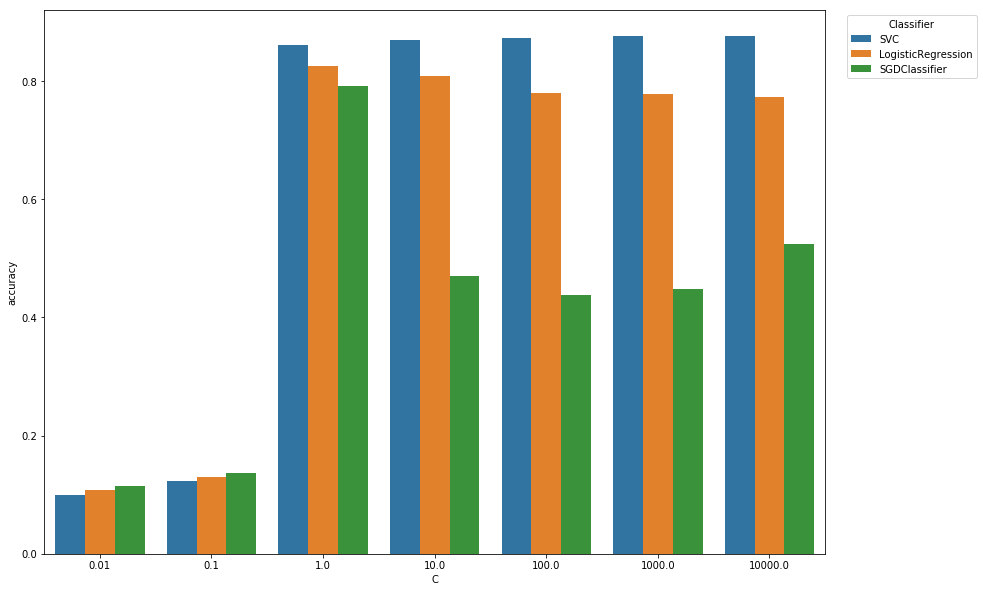

In [7]:
cv_results = grid_search.cv_results_
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_


params = np.array(grid_search.cv_results_['params'])
mean_scores = np.array(grid_search.cv_results_['mean_test_score'])

classifier_labels=['SVC','LogisticRegression','SGDClassifier']

classifier_temp = pd.DataFrame(columns=classifier_labels,index=C_OPTIONS,
                               data=np.linspace(.1,.25,num=len(C_OPTIONS)*len(classifier_labels)).reshape(len(C_OPTIONS),len(classifier_labels)))
classifier_temp.fillna(0,inplace=True)

for i, (param, score) in enumerate(zip(params, mean_scores)):
    C = param['clf__C'] if 'clf__C' in param else param['clf__alpha']
    class_state = str(param['clf']).split('(')[0]
    if classifier_temp.at[C,class_state] < score:
        classifier_temp.at[C,class_state] = score


display(classifier_temp.transpose())        
        
classifier_temp['C']=classifier_temp.index
classifier_temp= classifier_temp.set_index(['C']).stack().reset_index(name='accuracy').rename(columns={'level_1':'Classifier'})
                
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.barplot(x="C",y='accuracy',hue='Classifier',data=classifier_temp);
leg = plt.legend( loc = 'upper right',title='Classifier')
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# Change to location of the legend. 
xOffset = .20
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

,25,50,100,150,None
NMF,0.718014,0.736950,0.777892,0.768168,0.863869
SelectKBest,0.632037,0.876151,0.861822,0.858240,0.863869


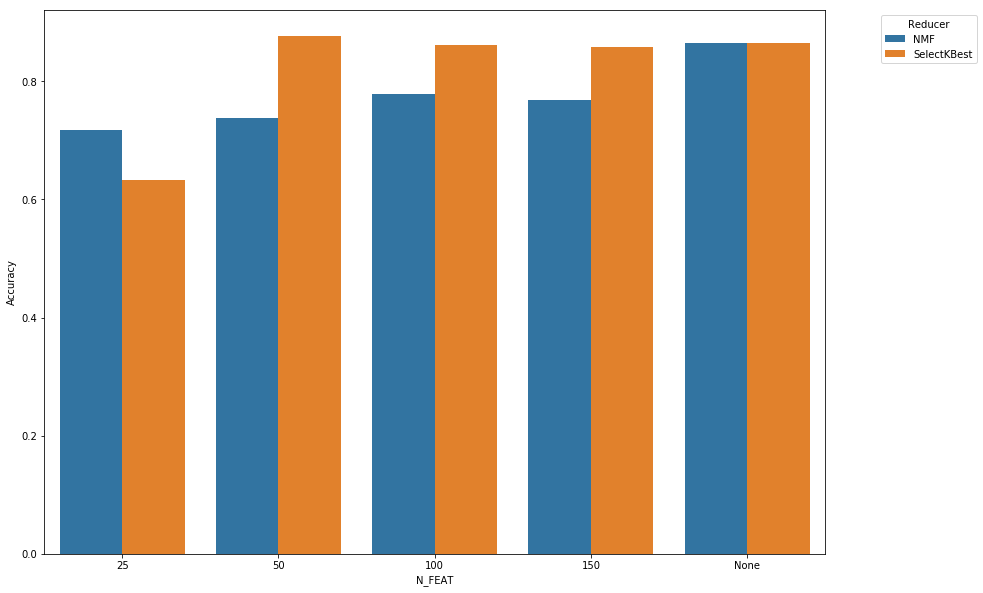

In [8]:
params = np.array(grid_search.cv_results_['params'])
mean_scores = np.array(grid_search.cv_results_['mean_test_score'])

reduce_labels=['NMF','SelectKBest']

temp_N_FEATURES_OPTIONS = [str(r) for r in N_FEATURES_OPTIONS]
temp_N_FEATURES_OPTIONS=temp_N_FEATURES_OPTIONS+['None']

reduce_temp = pd.DataFrame(columns=reduce_labels,index=temp_N_FEATURES_OPTIONS,
                               data=np.linspace(.1,.25,num=len(temp_N_FEATURES_OPTIONS)*len(reduce_labels)).reshape(+len(temp_N_FEATURES_OPTIONS),len(reduce_labels)))


for i, (param, score) in enumerate(zip(params, mean_scores)):
    trigger=0
    reduce_state = str(param['reduce_dim']).split('(')[0]
    if 'reduce_dim__k' in param:
        N_FEAT = str(param['reduce_dim__k'])
        trigger=1
    elif 'reduce_dim__n_components' in param:
        N_FEAT = str(param['reduce_dim__n_components'])
        trigger=1
    else:
        if reduce_temp.at['None','NMF'] < score:
            reduce_temp.at['None','NMF'] = score
            reduce_temp.at['None','SelectKBest'] = score
        
    if trigger == 1:
        if reduce_temp.at[N_FEAT,reduce_state] < score:
            reduce_temp.at[N_FEAT,reduce_state] = score
            

display(reduce_temp.transpose())
            
reduce_temp['N_FEAT']=reduce_temp.index
reduce_temp= reduce_temp.set_index(['N_FEAT']).stack().reset_index(name='Accuracy').rename(columns={'level_1':'Reducer'})
                
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.barplot(x="N_FEAT",y='Accuracy',hue='Reducer',data=reduce_temp);
leg = plt.legend( loc = 'upper right',title='Reducer')
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# Change to location of the legend. 
xOffset = .20
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


In [9]:
#print(grid_search.best_estimator_)
display(grid_search.best_index_)
display(grid_search.best_params_)
display(grid_search.best_score_)

177

{'clf': SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'clf__C': 1000.0,
 'reduce_dim': SelectKBest(k=50, score_func=<function chi2 at 0x000001CE098B2B70>),
 'reduce_dim__k': 50,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

0.8761514841351075

# Model Advantages
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Looking at the accuracy of the two models there are a couple of obvious observations.

1. SVM is negatively to non-standardized observations.
2. Logistic Regression ...

# Interpret Feature Importance
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?


# Interpret Support Vectors
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.